# Data

**Imaging Data Description**

All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes, and were acquired with different clinical protocols and various scanners from multiple (n=19) institutions, mentioned as data contributors here.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.


## Load data + Samples

In [1]:
# Import libraries

import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data
import nibabel as nib
import requests
import io
import random, zipfile
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
MODALITIES = ['flair', 't1', 't1ce', 't2']

# 1) Extract if needed: kaggel or colab
extract_path = "/kaggle/input/imiap-u-net"
# zip_path     = "/content/drive/MyDrive/train_data.zip"
# extract_path = "/content/drive/MyDrive/train_data"
if not os.path.isdir(extract_path):
    print(f"Extracting {zip_path} → {extract_path} …")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_path)
    print("Done.")
else:
    print("Already extracted.")

# 2) Fixed Dataset that grabs every subdirectory:
class BraTSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        # List any immediate subdirectory
        self.folders = sorted(
            [os.path.join(root_dir, d)
             for d in os.listdir(root_dir)
             if os.path.isdir(os.path.join(root_dir, d))]
        )
        if len(self.folders) == 0:
            raise RuntimeError(f"No subfolders found in {root_dir}")
        self.transform = transform

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder = self.folders[idx]
        base   = os.path.basename(folder)

        # load and normalize modalities into x of shape (4, H, W, 1)
        scans = []
        for m in MODALITIES:
            img = nib.load(os.path.join(folder, f"BraTS20_Training_{base}_{m}.nii")).get_fdata()
            img = (img - img.min()) / (img.max() - img.min())
            scans.append(img.astype(np.float32))
        x = np.stack(scans, axis=0)

        # load seg of shape (H, W, 1)
        y = nib.load(os.path.join(folder, f"BraTS20_Training_{base}_seg.nii")).get_fdata()
        y = (y > 0).astype(np.float32)

        # optional augment
        if self.transform:
            x, y = self.transform(x, y)

        # —— Squeeze singleton “slice” dimension ——
        if x.ndim == 4 and x.shape[-1] == 1:
            x = x[..., 0]
        if y.ndim == 3 and y.shape[-1] == 1:
            y = y[..., 0]

        x_tensor = torch.from_numpy(x)               # → (4, H, W)
        y_tensor = torch.from_numpy(y).unsqueeze(0)  # → (1, H, W)

        return x_tensor, y_tensor

# 3) Simple random flip/rotate
def random_flip_rotate(x, y):
    if random.random() > 0.5:
        x = np.flip(x, axis=2).copy()
        y = np.flip(y, axis=1).copy()
    if random.random() > 0.5:
        x = np.rot90(x, k=1, axes=(1,2)).copy()
        y = np.rot90(y, k=1, axes=(0,1)).copy()
    return x, y

# 4) Instantiate, split, and DataLoaders
root = extract_path
dataset = BraTSDataset(root_dir=root)

val_frac = 0.2
n_total  = len(dataset)
n_val    = int(n_total * val_frac)
n_train  = n_total - n_val

train_ds, val_ds = random_split(dataset, [n_train, n_val])
train_ds.dataset.transform = random_flip_rotate
val_ds.dataset.transform   = None

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2)
val_dataloader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

print(f"Found {n_total} cases → {n_train} train / {n_val} val.")


Already extracted.
Found 354 cases → 284 train / 70 val.


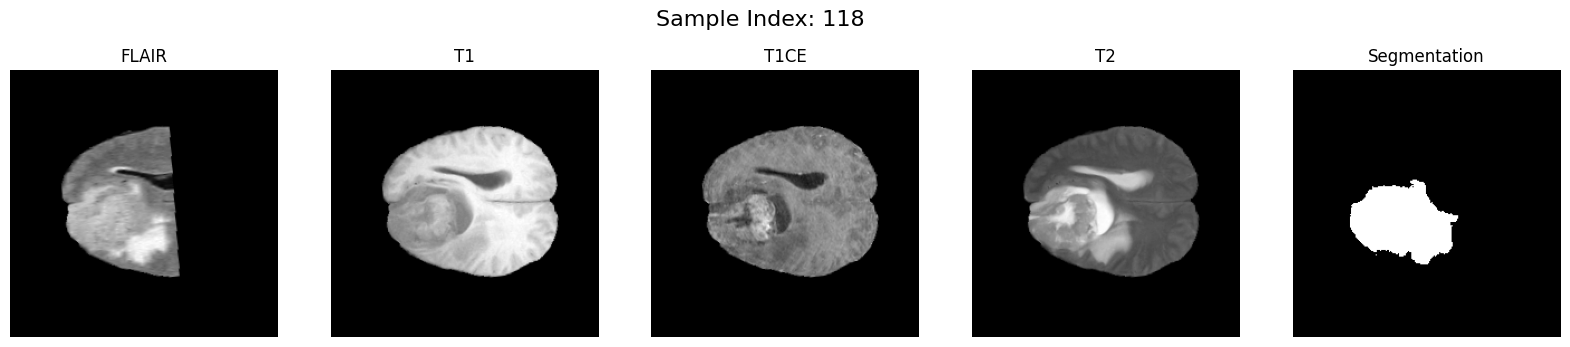

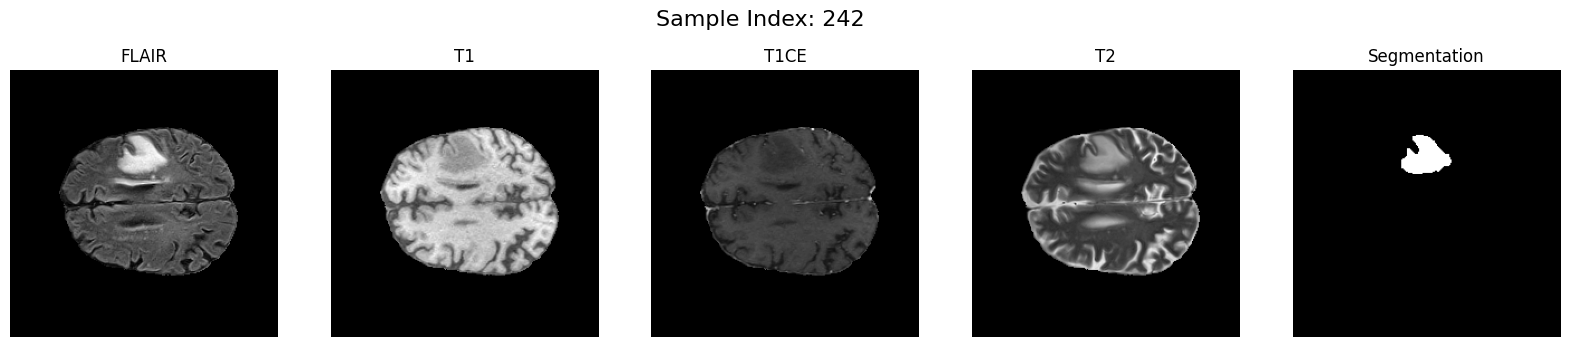

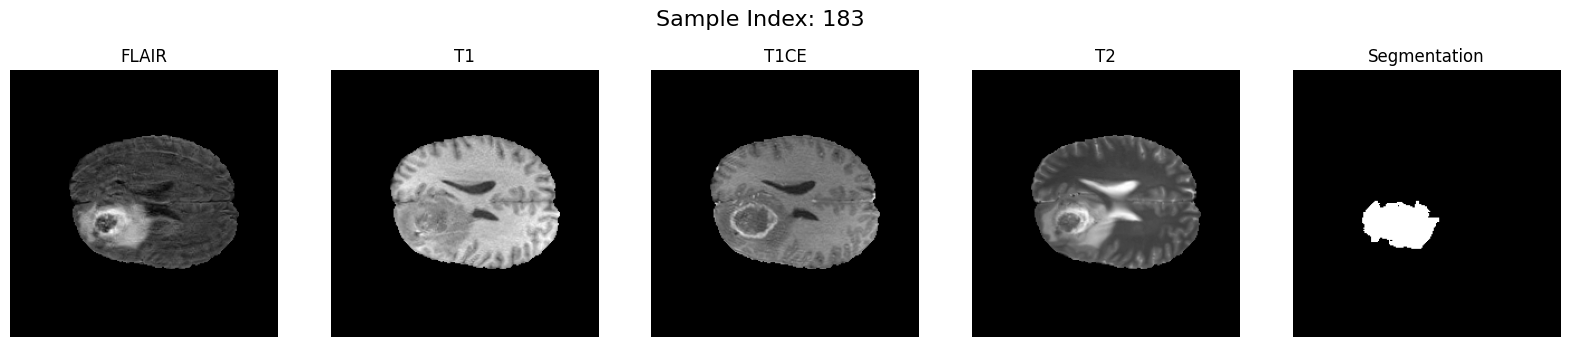

In [3]:
import matplotlib.pyplot as plt

def plot_sample(dataset, index=0):
    x, y = dataset[index]  # x shape: [4, H, W], y shape: [1, H, W]
    modalities = ['FLAIR', 'T1', 'T1CE', 'T2']
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    for i in range(4):
        axes[i].imshow(x[i], cmap='gray')
        axes[i].set_title(modalities[i])
        axes[i].axis('off')

    axes[4].imshow(y[0], cmap='gray')
    axes[4].set_title("Segmentation")
    axes[4].axis('off')

    plt.suptitle(f"Sample Index: {index}", fontsize=16)
    plt.show()

# Plot 3 random training samples
for idx in np.random.choice(len(train_ds), 3, replace=False):
    plot_sample(train_ds, idx)


# <a id='toc1_3_3_'></a>[U-Net Model](#toc0_)


**U-Net** is a fully convolutional neural network originally designed for semantic image segmentation of biomedical images. This network features a distinctive encoder-decoder structure, making it exceptionally effective for detailed and precise image analysis tasks in the medical field. Since its inception, U-Net has been widely recognized for its robust performance in segmenting complex anatomical structures in medical scans, such as MRIs and CT images.

The architecture of U-Net is particularly notable for its ability to capture contextual information at various scales, which is crucial for accurate segmentation. The encoder part of the network progressively reduces the spatial dimension of the image, capturing high-level semantic information. Conversely, the decoder part gradually recovers object details and spatial dimensions, ensuring precise localization.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Kk-yKGkvRtkNzLkZdP3Pag/unet.png" width="70%" alt="indexing"/>

**Reference:**
1. Original Paper: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)


**1. Input Image Tile**  
- **Dimensions**: 572 × 572, with 1 channel (grayscale)  
- Serves as the input to the U-Net for segmentation  
- Passes through convolution and pooling layers for feature extraction  

**2. Convolution Blocks (Conv 3×3, ReLU)**  
- Represented by pairs of 3×3 convolutions followed by ReLU activation  
- Feature map depth increases: 64 → 128 → 256 → 512 → 1024  
- Responsible for extracting hierarchical image features  

**3. Downsampling (Max Pool 2×2)**  
- Reduces spatial dimensions by a factor of 2  
- Retains the most prominent features while losing spatial detail  
- Forms the contracting path on the left  

**4. Bottleneck**  
- Central part of the architecture  
- Has the deepest feature maps with highest abstraction  
- Balances context with reduced resolution  

**5. Upsampling (Up-Conv 2×2)**  
- Increases spatial dimensions by a factor of 2  
- Reduces feature map depth while restoring resolution  
- Forms the expanding path on the right  

**6. Copy and Crop / Skip Connections**  
- Copies feature maps from the contracting path and crops them to match dimensions  
- Concatenates them with upsampled maps to preserve spatial accuracy  
- Combines deep semantic information with shallow spatial detail  

**7. Output Convolution (1×1 Conv)**  
- Applies a 1×1 convolution to map each pixel to output classes  
- Final result is a pixel-wise classification map  
- Enables precise segmentation boundaries  

**Summary Table**

| **Stage**           | **Operation**                 | **Purpose**                              |
|---------------------|-------------------------------|------------------------------------------|
| Input               | Image tile                    | Input for segmentation                   |
| Contracting Path    | Conv 3×3, ReLU + MaxPool      | Feature extraction and downsampling      |
| Bottleneck          | Deepest layer                 | Global context representation            |
| Expanding Path      | Up-conv + Skip connections    | Resolution recovery and spatial merging  |
| Output Layer        | 1×1 convolution               | Pixel-wise classification                |


## Network

Let's construct a U-Net model for the dataset.

In [ ]:
import torch.nn as nn

def double_convolution(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.enc1 = double_convolution(4, 64)
        self.enc2 = double_convolution(64, 128)
        self.enc3 = double_convolution(128,256)
        self.enc4 = double_convolution(256,512)
        self.center = double_convolution(512,1024)
        self.pool = nn.MaxPool2d(2)
        self.up1 = nn.ConvTranspose2d(1024,512,2,2)
        self.dec1 = double_convolution(1024,512)
        self.up2 = nn.ConvTranspose2d(512,256,2,2)
        self.dec2 = double_convolution(512,256)
        self.up3 = nn.ConvTranspose2d(256,128,2,2)
        self.dec3 = double_convolution(256,128)
        self.up4 = nn.ConvTranspose2d(128,64,2,2)
        self.dec4 = double_convolution(128,64)
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        c = self.center(self.pool(e4))
        d1 = self.dec1(torch.cat([self.up1(c), e4], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d1), e3], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d2), e2], dim=1))
        d4 = self.dec4(torch.cat([self.up4(d3), e1], dim=1))
        return self.out(d4)


## Loss

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        num = 2*(inputs*targets).sum(dim=(1,2,3)) + self.smooth
        den = inputs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + self.smooth
        return 1 - (num/den).mean()

class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        return self.bce(inputs, targets) + self.dice(inputs, targets)


## Train

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

# --- 1️⃣ Define your three criterions ---
criterions = {
    'BCE': nn.BCEWithLogitsLoss(),
    'Dice': DiceLoss(),
    'Combo': DiceBCELoss()
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2️⃣ Prepare a results container ---
results = {}

# --- 3️⃣ Loop over each loss, reinitialize model+optimizer every time ---
for name, criterion in criterions.items():
    print(f"\n=== Training with {name} loss ===")
    model = UNet(num_classes=1).to(device)
    optimizer = Adam(model.parameters(), lr=1e-4)
    epochs = 20

    train_losses = []
    val_losses   = []

    for epoch in range(epochs):
        # — Training —
        model.train()
        running_loss = 0.0
        for xb, yb in tqdm(train_dataloader, desc=f"{name} ▶ Epoch {epoch+1}/{epochs} — Train"):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss  = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_dataloader))

        # — Validation —
        model.eval()
        val_running = 0.0
        with torch.no_grad():
            for xb, yb in tqdm(val_dataloader, desc=f"{name} ▶ Epoch {epoch+1}/{epochs} — Val"):
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_running += criterion(preds, yb).item()
        val_losses.append(val_running / len(val_dataloader))

        print(f"{name} | Epoch {epoch+1:02d} — Train: {train_losses[-1]:.4f} | Val: {val_losses[-1]:.4f}")

    # store losses & trained model
    results[name] = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses
    }


=== Training with BCE loss ===


BCE ▶ Epoch 1/20 — Val: 100%|██████████| 9/9 [00:04<00:00,  2.19it/s]


BCE | Epoch 01 — Train: 0.5260 | Val: 0.2445


BCE ▶ Epoch 2/20 — Val: 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]


BCE | Epoch 02 — Train: 0.1211 | Val: 0.0937


BCE ▶ Epoch 3/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


BCE | Epoch 03 — Train: 0.0747 | Val: 0.0725


BCE ▶ Epoch 4/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


BCE | Epoch 04 — Train: 0.0616 | Val: 0.0617


BCE ▶ Epoch 5/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]


BCE | Epoch 05 — Train: 0.0568 | Val: 0.0549


BCE ▶ Epoch 6/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


BCE | Epoch 06 — Train: 0.0498 | Val: 0.0447


BCE ▶ Epoch 7/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]


BCE | Epoch 07 — Train: 0.0457 | Val: 0.0413


BCE ▶ Epoch 8/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]


BCE | Epoch 08 — Train: 0.0462 | Val: 0.0360


BCE ▶ Epoch 9/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]


BCE | Epoch 09 — Train: 0.0393 | Val: 0.0396


BCE ▶ Epoch 10/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]


BCE | Epoch 10 — Train: 0.0402 | Val: 0.0490


BCE ▶ Epoch 11/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]


BCE | Epoch 11 — Train: 0.0385 | Val: 0.0358


BCE ▶ Epoch 12/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


BCE | Epoch 12 — Train: 0.0355 | Val: 0.0348


BCE ▶ Epoch 13/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]


BCE | Epoch 13 — Train: 0.0337 | Val: 0.0333


BCE ▶ Epoch 14/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]


BCE | Epoch 14 — Train: 0.0333 | Val: 0.0317


BCE ▶ Epoch 15/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


BCE | Epoch 15 — Train: 0.0312 | Val: 0.0336


BCE ▶ Epoch 16/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]


BCE | Epoch 16 — Train: 0.0296 | Val: 0.0360


BCE ▶ Epoch 17/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


BCE | Epoch 17 — Train: 0.0295 | Val: 0.0317


BCE ▶ Epoch 18/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


BCE | Epoch 18 — Train: 0.0254 | Val: 0.0282


BCE ▶ Epoch 19/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


BCE | Epoch 19 — Train: 0.0260 | Val: 0.0286


BCE ▶ Epoch 20/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.96it/s]


BCE | Epoch 20 — Train: 0.0261 | Val: 0.0292

=== Training with Dice loss ===


Dice ▶ Epoch 1/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


Dice | Epoch 01 — Train: 0.9473 | Val: 0.9174


Dice ▶ Epoch 2/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]


Dice | Epoch 02 — Train: 0.8594 | Val: 0.6559


Dice ▶ Epoch 3/20 — Val: 100%|██████████| 9/9 [00:02<00:00,  3.00it/s]


Dice | Epoch 03 — Train: 0.5965 | Val: 0.5306


Dice ▶ Epoch 4/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


Dice | Epoch 04 — Train: 0.5407 | Val: 0.4925


Dice ▶ Epoch 5/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s]


Dice | Epoch 05 — Train: 0.5083 | Val: 0.5367


Dice ▶ Epoch 6/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


Dice | Epoch 06 — Train: 0.5056 | Val: 0.4959


Dice ▶ Epoch 7/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


Dice | Epoch 07 — Train: 0.4870 | Val: 0.4766


Dice ▶ Epoch 8/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]


Dice | Epoch 08 — Train: 0.4843 | Val: 0.5182


Dice ▶ Epoch 9/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]


Dice | Epoch 09 — Train: 0.4940 | Val: 0.4962


Dice ▶ Epoch 10/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]


Dice | Epoch 10 — Train: 0.4996 | Val: 0.4959


Dice ▶ Epoch 11/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]


Dice | Epoch 11 — Train: 0.4774 | Val: 0.4891


Dice ▶ Epoch 12/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]


Dice | Epoch 12 — Train: 0.4661 | Val: 0.4582


Dice ▶ Epoch 13/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]


Dice | Epoch 13 — Train: 0.4634 | Val: 0.4700


Dice ▶ Epoch 14/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


Dice | Epoch 14 — Train: 0.4568 | Val: 0.4658


Dice ▶ Epoch 15/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.26it/s]


Dice | Epoch 15 — Train: 0.4598 | Val: 0.4583


Dice ▶ Epoch 16/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]


Dice | Epoch 16 — Train: 0.4651 | Val: 0.4753


Dice ▶ Epoch 17/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


Dice | Epoch 17 — Train: 0.4576 | Val: 0.4552


Dice ▶ Epoch 18/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


Dice | Epoch 18 — Train: 0.4635 | Val: 0.4678


Dice ▶ Epoch 19/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]


Dice | Epoch 19 — Train: 0.4745 | Val: 0.4716


Dice ▶ Epoch 20/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]


Dice | Epoch 20 — Train: 0.4545 | Val: 0.4481

=== Training with Combo loss ===


Combo ▶ Epoch 1/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


Combo | Epoch 01 — Train: 1.5229 | Val: 1.2852


Combo ▶ Epoch 2/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


Combo | Epoch 02 — Train: 1.0471 | Val: 0.9247


Combo ▶ Epoch 3/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]


Combo | Epoch 03 — Train: 0.8401 | Val: 0.7802


Combo ▶ Epoch 4/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]


Combo | Epoch 04 — Train: 0.7191 | Val: 0.6440


Combo ▶ Epoch 5/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


Combo | Epoch 05 — Train: 0.6271 | Val: 0.6392


Combo ▶ Epoch 6/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


Combo | Epoch 06 — Train: 0.5913 | Val: 0.5455


Combo ▶ Epoch 7/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]


Combo | Epoch 07 — Train: 0.5576 | Val: 0.6180


Combo ▶ Epoch 8/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]


Combo | Epoch 08 — Train: 0.5605 | Val: 0.5290


Combo ▶ Epoch 9/20 — Val: 100%|██████████| 9/9 [00:02<00:00,  3.00it/s]


Combo | Epoch 09 — Train: 0.5510 | Val: 0.5512


Combo ▶ Epoch 10/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]


Combo | Epoch 10 — Train: 0.5387 | Val: 0.5652


Combo ▶ Epoch 11/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]


Combo | Epoch 11 — Train: 0.5297 | Val: 0.5111


Combo ▶ Epoch 12/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]


Combo | Epoch 12 — Train: 0.5281 | Val: 0.5524


Combo ▶ Epoch 13/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]


Combo | Epoch 13 — Train: 0.5086 | Val: 0.5005


Combo ▶ Epoch 14/20 — Val: 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


Combo | Epoch 14 — Train: 0.5070 | Val: 0.4958


Combo ▶ Epoch 15/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]


Combo | Epoch 15 — Train: 0.4825 | Val: 0.4870


Combo ▶ Epoch 16/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.38it/s]


Combo | Epoch 16 — Train: 0.4928 | Val: 0.5126


Combo ▶ Epoch 17/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]


Combo | Epoch 17 — Train: 0.4873 | Val: 0.4943


Combo ▶ Epoch 18/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]


Combo | Epoch 18 — Train: 0.4900 | Val: 0.4911


Combo ▶ Epoch 19/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s]


Combo | Epoch 19 — Train: 0.4850 | Val: 0.5369


Combo ▶ Epoch 20/20 — Val: 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]

Combo | Epoch 20 — Train: 0.4751 | Val: 0.5379


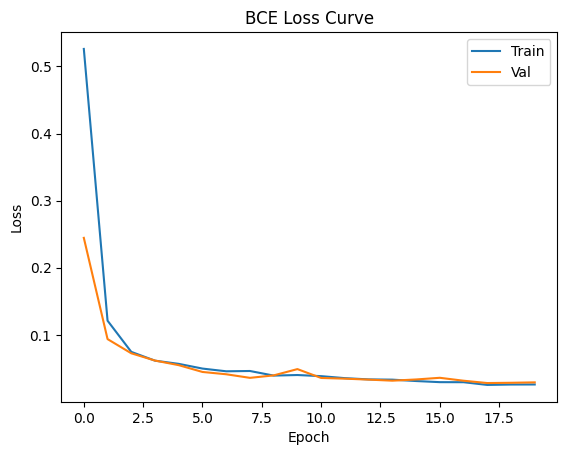

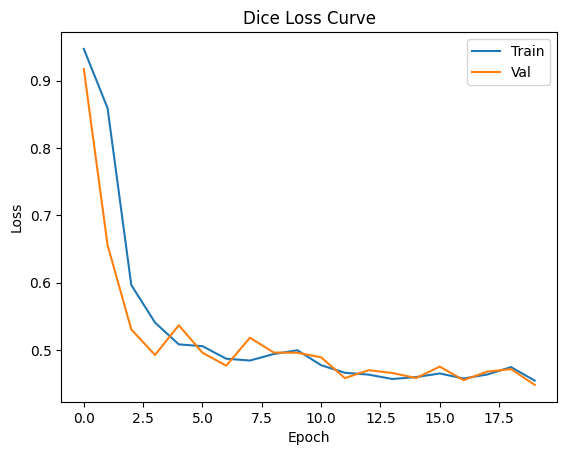

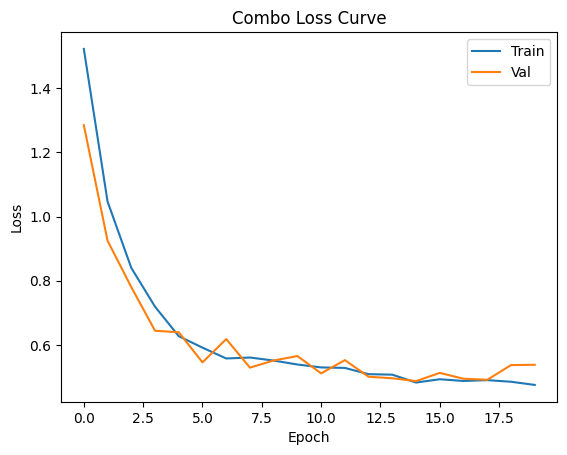

In [ ]:
# --- 4️⃣ Plot Loss Curves for each loss type ---
for name, res in results.items():
    plt.figure()
    plt.plot(res['train_losses'], label='Train')
    plt.plot(res['val_losses'],   label='Val')
    plt.title(f"{name} Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

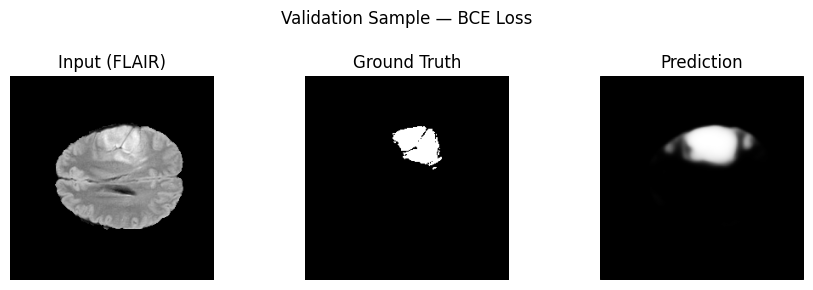

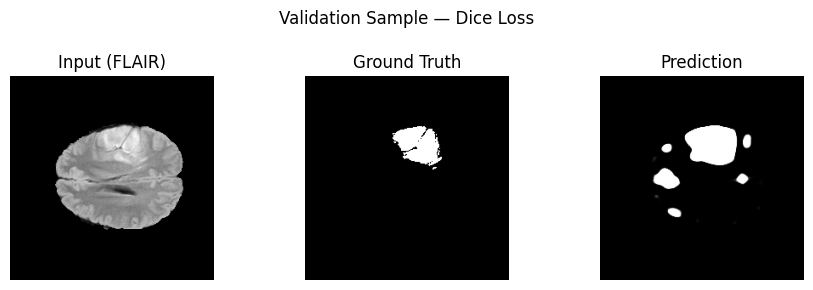

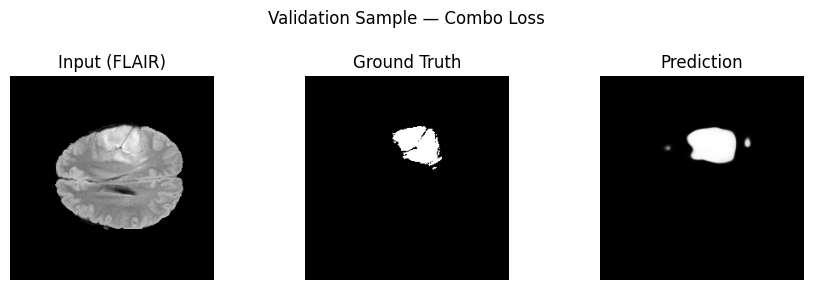

In [ ]:
# --- 5️⃣ Sample Validation Predictions for each trained model ---
#    We take the first batch from val_dataloader and index 0 within it
for name, res in results.items():
    model = res['model']
    model.eval()

    xb, yb = next(iter(val_dataloader))
    xb, yb = xb.to(device), yb.to(device)
    with torch.no_grad():
        preds = torch.sigmoid(model(xb)).cpu().numpy()

    xb = xb.cpu().numpy()
    yb = yb.cpu().numpy()

    idx = 0  # you can loop multiple indices if you like
    plt.figure(figsize=(9,3))
    plt.suptitle(f"Validation Sample — {name} Loss")

    # show first modality (FLAIR) for context
    plt.subplot(1,3,1)
    plt.imshow(xb[idx,0], cmap='gray')
    plt.title("Input (FLAIR)")
    plt.axis('off')

    # ground truth
    plt.subplot(1,3,2)
    plt.imshow(yb[idx,0], cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    # model prediction
    plt.subplot(1,3,3)
    plt.imshow(preds[idx,0], cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# U-Net with Attention

Now we augment the regular UNet with several sub-modules and techniques such as ResNets, Attention modules, etc. We describe the expected architecture for this notebook:

+ *ResNet:* As a base sub-module, we define each ResNet block as two consecutive convolutional layers with a GELU activation in between and Group Normalization after each convolutional layer. You can use this module in Down/Up blocks. Also, by removing the residual connection, you can use this block as a convolutional network throughout the network.
+ *Attention:* This is also a sub-module consisting of a Layer Normalization, Multi-head Attention (use from `torch.nn`), a residual connection, a feed-forward network, and another residual connection.

You can implement the following structure for UNet:

+ Convolutional block
+ Down block
+ Attention
+ Down block
+ Attention
+ Down block
+ Attention

+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)

+ Up block
+ Attention
+ Up block
+ Attention
+ Up block
+ Attention
+ Convolutional block

## Modules

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint

class ConvResNet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        # choose groups ≤ channels
        groups = min(8, out_ch)

        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.gn1   = nn.GroupNorm(groups, out_ch)
        self.gelu = nn.GELU()

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.gn2   = nn.GroupNorm(groups, out_ch)

        # residual skip
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.gelu(x)

        x = self.conv2(x)
        x = self.gn2(x)
        return self.gelu(x + identity)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = ConvResNet(in_ch, out_ch)

    def forward(self, x, t=None):
        x = self.pool(x)
        return self.conv(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = ConvResNet(in_ch, out_ch)

    def forward(self, x, skip, t=None):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, dim, heads=4, mlp_dim=128, pool_k=4):
        super().__init__()
        self.pool_k = pool_k
        self.norm1  = nn.LayerNorm(dim)
        self.attn   = nn.MultiheadAttention(dim, num_heads=heads, batch_first=True)
        self.norm2  = nn.LayerNorm(dim)
        self.ff     = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, dim)
        )

    def forward(self, x):
        # x: (B, C, H, W)
        B,C,H,W = x.shape

        # 1) Downsample spatially by factor pool_k
        x_small = F.avg_pool2d(x, kernel_size=self.pool_k, stride=self.pool_k)  # (B,C,H/4,W/4)

        # 2) Prepare for MH-Attn
        bs, c, hs, ws = x_small.shape
        N = hs * ws
        flat = x_small.view(bs, c, N).permute(0,2,1)       # (B, N, C)
        normed = self.norm1(flat)

        # 3) Self-attention
        attn_out, _ = self.attn(normed, normed, normed)    # (B, N, C)
        res1 = flat + attn_out

        # 4) FFN with residual
        ff = self.ff(self.norm2(res1))
        res2 = res1 + ff                                   # (B, N, C)

        # 5) Restore spatial dims
        out_small = res2.permute(0,2,1).view(bs, c, hs, ws)  # (B,C,H/4,W/4)
        out = F.interpolate(out_small, size=(H,W), mode='bilinear', align_corners=False)

        # 6) Residual + return
        return x + out

class UNet_Attention(nn.Module):
    def __init__(self, in_ch=4, base_ch=32, num_classes=1):
        super(UNet_Attention, self).__init__()
        self.conv0 = ConvResNet(in_ch, base_ch)            # 240×240 → 32 ch

        self.down1 = Down(base_ch, base_ch * 2)             # → 120×120, 64 ch
        self.attn1 = AttentionBlock(base_ch * 2)

        self.down2 = Down(base_ch * 2, base_ch * 4)         # → 60×60, 128 ch
        self.attn2 = AttentionBlock(base_ch * 4)

        self.down3 = Down(base_ch * 4, base_ch * 8)         # → 30×30, 256 ch
        self.attn3 = AttentionBlock(base_ch * 8)

        self.bottleneck = nn.Sequential(                    # stays 30×30, 256 ch
            ConvResNet(base_ch * 8, base_ch * 8),
            ConvResNet(base_ch * 8, base_ch * 8),
            ConvResNet(base_ch * 8, base_ch * 8),
        )

        # UP path
        self.up1   = Up(base_ch * 8, base_ch * 4)            # 30→60, in 512 ch, out 128 ch
        self.attn4 = AttentionBlock(base_ch * 4)

        self.up2   = Up(base_ch * 4, base_ch * 2)            # 60→120, in 256 ch, out 64 ch
        self.attn5 = AttentionBlock(base_ch * 2)

        self.up3   = Up(base_ch * 2, base_ch)                # 120→240, in 128 ch, out 32 ch
        # ⚠ No high-res attention here  
        self.final = ConvResNet(base_ch, num_classes)       # → 1-channel mask

    def forward(self, x, t=None):
            # contracting
            c0  = self.conv0(x)                       # 240→240
            d1  = checkpoint(self.down1, c0)          # checkpointed
            d1a = checkpoint(self.attn1, d1)
    
            d2  = checkpoint(self.down2, d1a)
            d2a = checkpoint(self.attn2, d2)
    
            d3  = checkpoint(self.down3, d2a)
            d3a = checkpoint(self.attn3, d3)
    
            # bottleneck (3× heavy ConvResNet)
            b = checkpoint(self.bottleneck, d3a)
    
            # expanding
            u1  = checkpoint(self.up1, b, d2a)
            u1a = checkpoint(self.attn4, u1)
    
            u2  = checkpoint(self.up2, u1a, d1a)
            u2a = checkpoint(self.attn5, u2)
    
            u3  = checkpoint(self.up3, u2a, c0)
            out = checkpoint(self.final, u3)
    
            return out

## Train with BCE Loss

In [17]:
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet_Attention().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 20

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_running = 0
    for xb, yb in tqdm(train_dataloader, desc=f"Train Epoch {epoch+1}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_running += loss.item()
    train_losses.append(train_running / len(train_dataloader))

    model.eval()
    val_running = 0
    with torch.no_grad():
        for xb, yb in tqdm(val_dataloader, desc="Val Epoch"):
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_running += criterion(preds, yb).item()
    val_losses.append(val_running / len(val_dataloader))
    print(f"Epoch {epoch+1}: Train={train_losses[-1]:.4f}, Val={val_losses[-1]:.4f}")
    torch.cuda.empty_cache()

Val Epoch: 100%|██████████| 9/9 [00:00<00:00,  9.82it/s]


Epoch 1: Train=0.6614, Val=0.6111


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 11.55it/s]


Epoch 2: Train=0.6108, Val=0.6096


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 10.34it/s]


Epoch 3: Train=0.6089, Val=0.6087


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 11.08it/s]


Epoch 4: Train=0.6082, Val=0.6054


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 11.45it/s]


Epoch 5: Train=0.6070, Val=0.6069


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 10.35it/s]


Epoch 6: Train=0.6063, Val=0.6041


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 10.91it/s]


Epoch 7: Train=0.6057, Val=0.6034


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 11.22it/s]


Epoch 8: Train=0.6063, Val=0.6095


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 10.65it/s]


Epoch 9: Train=0.6061, Val=0.6056


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 10.51it/s]


Epoch 10: Train=0.6050, Val=0.6041


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 11.04it/s]


Epoch 11: Train=0.6047, Val=0.6056


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 10.99it/s]


Epoch 12: Train=0.6044, Val=0.6025


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 11.10it/s]


Epoch 13: Train=0.6039, Val=0.6044


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 11.29it/s]


Epoch 14: Train=0.6040, Val=0.6029


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 11.80it/s]


Epoch 15: Train=0.6038, Val=0.6033


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 11.05it/s]


Epoch 16: Train=0.6056, Val=0.6080


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 10.98it/s]


Epoch 17: Train=0.6048, Val=0.6029


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 10.92it/s]


Epoch 18: Train=0.6035, Val=0.6020


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 10.63it/s]


Epoch 19: Train=0.6033, Val=0.6006


Val Epoch: 100%|██████████| 9/9 [00:00<00:00, 11.81it/s]

Epoch 20: Train=0.6033, Val=0.6024


## Loss Curves & Sample Outputs

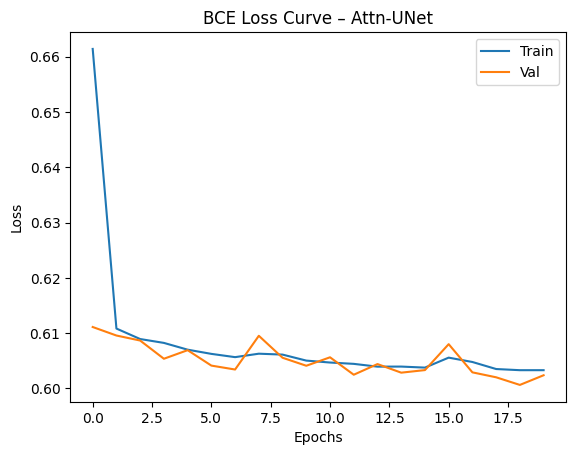

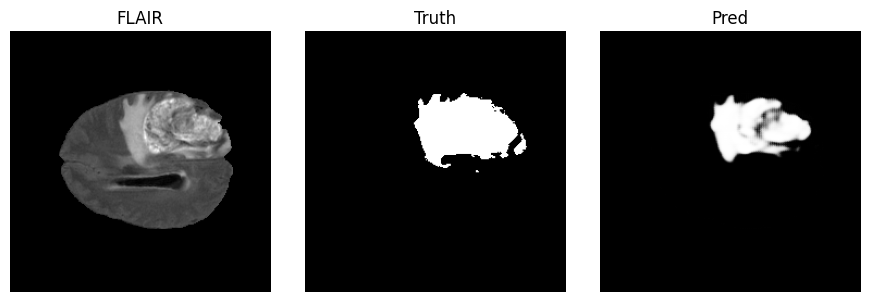

In [18]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.title("BCE Loss Curve – Attn‑UNet")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()
plt.show()

# Display a sample validation mask
model.eval()
xb, yb = next(iter(val_dataloader))
xb, yb = xb.to(device), yb.to(device)
with torch.no_grad():
    preds = torch.sigmoid(model(xb)).cpu().numpy()
xb, yb = xb.cpu().numpy(), yb.cpu().numpy()

idx = 0
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(xb[idx,0], cmap='gray'); plt.title("FLAIR"); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(yb[idx,0], cmap='gray'); plt.title("Truth"); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(preds[idx,0], cmap='gray'); plt.title("Pred"); plt.axis('off')
plt.tight_layout(); plt.show()